In [2]:
import numpy as np
import pandas as pd
import os
from pypinyin import pinyin, lazy_pinyin, Style
import matplotlib.pyplot as plt
import econtools.metrics as mt
import matplotlib
import seaborn as sns
from matplotlib import font_manager
import datetime
from thefuzz import fuzz
from thefuzz import process

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['font.family'] = ['Heiti TC']

In [3]:
def pinyin(name):
    i = lazy_pinyin(name)
    if len(i) == 3:
        capitalized = [str.capitalize(i[0]),str.capitalize(i[1]+i[2])]
    elif len(i) == 2:
        capitalized = [str.capitalize(i[0]),str.capitalize(i[1])]
    else:
        #print(i)
        capitalized = i
    return capitalized
def surname(name):
    i = lazy_pinyin(name)
    if len(i) == 3:
        capitalized = str.capitalize(i[0])
    elif len(i) == 2:
        capitalized = str.capitalize(i[0])
    else:
        #print(i)
        capitalized = i[0]
    return capitalized
def givenname(name):
    i = lazy_pinyin(name)
    if len(i) == 3:
        capitalized = str.capitalize(i[1]+i[2])
    elif len(i) == 2:
        capitalized = str.capitalize(i[1])
    else:
        #print(i)
        capitalized = i[0]
    return capitalized

## 基金数据

In [4]:
ms_all = pd.read_csv("/Users/yansong/Nutstore Files/基金研究/data/2013--2022面青/ms_all.csv")
ms_all['nsfc_code'] = ms_all['申请代码'].str[0:1]
ms_all['申请部门'].fillna('missing',inplace=True) ## 14年数据缺少申请部门，先简单补充
ms_all['立项年份'] = ms_all['年份']*ms_all['立项']
ms_all = pd.DataFrame(ms_all.groupby(['申请人','申请部门','nsfc_code']).立项年份.max()).reset_index()

ms_all['pinyin']= ms_all['申请人'].apply(pinyin)
ms_all['surname'] = ms_all['申请人'].apply(surname)
ms_all['givenname'] = ms_all['申请人'].apply(givenname)
ms_all['author_name'] = ms_all['surname']+' '+ms_all['givenname']
ms_nsfc = ms_all.groupby(by=['申请人','申请部门','nsfc_code','author_name'])['立项年份'].sum().reset_index()[['申请人','author_name','nsfc_code','申请部门','立项年份']]

In [5]:
ms_nsfc.head(20)

,申请人,author_name,nsfc_code,申请部门,立项年份
0,ALEXANDER DEGELING,ALEXANDER DEGELING ALEXANDER DEGELING,D,威海校区,2017
1,Abdelwahid MELLOUKI,Abdelwahid MELLOUKI Abdelwahid MELLOUKI,B,环境研究院,2019
2,Balan Nanan,Balan Nanan Balan Nanan,D,威海校区,0
3,DONG MING WANG,DONG MING WANG DONG MING WANG,E,岩土工程中心,0
4,Hartmut Günter Dr. Herrmann,Hartmut Günter Dr. Herrmann Hartmut Günter Dr....,B,环境科学与工程学院,2019
5,Hiroshi Rikimaru,Hiroshi Rikimaru Hiroshi Rikimaru,C,物理学院,0
6,Jeongwoo Lee,Jeongwoo Lee Jeongwoo Lee,A,威海校区,2019
7,Jong-Sun Park,Jong-Sun Park Jong-Sun Park,D,威海校区,0
8,Kaufmann,Kaufmann Kaufmann,D,威海校区,0
9,Motoharu Nowada,Motoharu Nowada Motoharu Nowada,D,威海校区,0


## 论文数据

- Consolidate all publications with unique author eid
- Consolidate all author_eids
- Merge the two using author_eid 
- Reshape to wide format

### 读取文章数据

In [6]:
root_dir = "/Users/yansong/Nutstore Files/论文发表2013-2020/ms_scopusPub/xlsx"
authors = os.listdir(root_dir)
os.chdir(root_dir)
lists_pubs = []
for author_file in authors:
    if '.xlsx' in author_file:
        author_pubs = pd.read_excel(author_file)
        if 'school 1' in author_pubs.columns:
            author_pubs = author_pubs[['affilname', 'afid', 'author_eid', 'author_names',
           'citedby_count', 'coverDate', 'doi', 'eid', 'title', 'school 1']]
            author_pubs.rename(columns={'school 1':'school_1'},inplace=True)
            lists_pubs.append(author_pubs)            
        elif 'school1' in author_pubs.columns:
            author_pubs = author_pubs[['affilname', 'afid', 'author_eid', 'author_names',
           'citedby_count', 'coverDate', 'doi', 'eid', 'title', 'school1']]
            author_pubs.rename(columns={'school1':'school_1'},inplace=True)
            lists_pubs.append(author_pubs)            
        elif 'school1' in author_pubs.columns:
            author_pubs = author_pubs[['affilname', 'afid', 'author_eid', 'author_names',
           'citedby_count', 'coverDate', 'doi', 'eid', 'title', 'school1']]
            author_pubs.rename(columns={'school1':'school_1'},inplace=True)
            lists_pubs.append(author_pubs)
        elif 'School1' in author_pubs.columns:
            author_pubs = author_pubs[['affilname', 'afid', 'author_eid', 'author_names',
           'citedby_count', 'coverDate', 'doi', 'eid', 'title', 'School1']]
            author_pubs.rename(columns={'School1':'school_1'},inplace=True)
            lists_pubs.append(author_pubs)            
        else:
            print(author_file)
ms_pubs = pd.concat(lists_pubs)    
ms_pubs.head(1)

ChenYan_转自CSV.xlsx
HaoAiyou_转自CSV.xlsx
BianZhongguo_转自CSV.xlsx
BaiMing_转自CSV.xlsx
ZhouJun_转自CSV.xlsx
XiaoHua_转自CSV.xlsx
HanBo_转自CSV.xlsx
HanBing_转自CSV.xlsx
MaChen_转自CSV.xlsx
WangTao_转自CSV.xlsx
ChenJian_转自CSV.xlsx


/var/folders/kp/gk4kvr5s0plbp5y3112cx_x00000gn/T/ipykernel_47968/189203793.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ms_pubs = pd.concat(lists_pubs)


,affilname,afid,author_eid,author_names,citedby_count,coverDate,doi,eid,title,school_1
0,Shandong University,60031031,55631012900,"Shi, Yongsen;Xue, Hanhan;Li, Jingyi;Yao, Yilin...",0,2023-03-01,10.1016/j.jenvman.2022.117010,2-s2.0-85145740623,Response of methanogenic system to long-term p...,环境科学与工程学院


In [7]:
ms_pubs['author_eid'] = pd.to_numeric(ms_pubs['author_eid'], errors='coerce')
type(ms_pubs['author_eid'].iloc[0])

numpy.int64

### 读取作者信息

In [8]:
root_dir = "/Users/yansong/Nutstore Files/基金研究/data/2013--2022面青/ms_scopus"
authors = os.listdir(root_dir)
os.chdir(root_dir)
unique_lists = []

for author_file in authors:
    if '.csv' in author_file:
        author_pubs = pd.read_csv(author_file)
        unique_lists.append(author_pubs)

author_ids = pd.concat(unique_lists)
author_ids['author_eid']= author_ids['eid'].str.split("-").str.get(2)
author_ids['author_eid'] = author_ids['author_eid'].astype('int64')
author_ids.drop(columns=['eid'],inplace=True)

In [9]:
len(author_ids.author_eid.unique())

4880

### 匹配作者和文章(merge on author_eid)

In [10]:
ms_author_pubs = ms_pubs.merge(author_ids,how='left',on='author_eid',indicator=True)
ms_author_pubs['date'] = ms_author_pubs['coverDate'].apply(str)
ms_author_pubs['year'] = ms_author_pubs['date'].str[0:4]
ms_author_pubs['author_name'] = ms_author_pubs['surname']+' ' +ms_author_pubs['givenname']
ms_author_pubs._merge.value_counts()

_merge
both          130537
left_only          0
right_only         0
Name: count, dtype: int64

In [11]:
ms_author_pubs.drop(columns=['_merge'],inplace=True,errors='ignore')
ms_author_pubs['citations'] = pd.to_numeric(ms_author_pubs['citedby_count'], errors='coerce')
ms_author_pubs['coauthors'] = ms_author_pubs.author_names.str.count(';')

### 转换为 author by year data

In [12]:
# ms_author_year_pubs4 = ms_author_pubs.groupby(['author_name','school_1','year'])['author_names'].apply('/'.join).reset_index()
# ms_author_year_pubs4['unique_coauthors'] = ms_author_year_pubs4.author_names.str.count(';')

#ms_author_pubs['coauthors'] = ms_author_pubs.author_names.str.count(';')

ms_author_year_pubs3 = ms_author_pubs.groupby(['author_name','school_1','year'])['coauthors'].mean().reset_index()

ms_author_year_pubs2 = ms_author_pubs.groupby(['author_name','school_1','year'])['citations'].sum().reset_index()

ms_author_year_pubs1 = ms_author_pubs.groupby(['author_name','school_1','year'])['author_eid'].count().reset_index()

ms_author_year_pubs  = ms_author_year_pubs1.merge(ms_author_year_pubs2,how='left',
                                                  on=['author_name','school_1','year'],indicator=True)

ms_author_year_pubs.drop(columns=['_merge'],inplace=True,errors='ignore')


In [13]:

ms_author_year_pubs = ms_author_year_pubs.merge(ms_author_year_pubs3,how='left',
                                                  on=['author_name','school_1','year'],indicator=True)
ms_author_year_pubs.drop(columns=['_merge'],inplace=True,errors='ignore')

# ms_author_year_pubs = ms_author_year_pubs.merge(ms_author_year_pubs4,how='left',
#                                                   on=['author_name','school_1','year'],indicator=True)
# ms_author_year_pubs.drop(columns=['_merge'],inplace=True,errors='ignore')


In [14]:
# pub_scatter = ms_author_year_pubs.groupby(['year']).author_eid.mean().reset_index()
# # pub_scatter = pub_scatter.loc[4:23,:] # select between 2003 and 2022
# pub_scatter['year'] = pd.to_numeric(pub_scatter['year'], errors='coerce')
# pub_scatter.drop(pub_scatter.loc[pub_scatter['year']<2003].index, inplace=True)
# pub_scatter.drop(pub_scatter.loc[pub_scatter['year']>2022].index, inplace=True)
# matplotlib.style.use('bmh') 
# fig, ax = plt.subplots(figsize=(8,6))
# scatter = ax.scatter(pub_scatter.year, pub_scatter.author_eid,cmap='tab20b')
# plt.xticks([2005,2010,2015,2020])
# plt.show()

In [15]:
# matplotlib.style.use('bmh') 
# #.hist(normed=True)
# plt.hist(np.clip(ms_author_year_pubs.groupby(['author_name']).author_eid.mean(),0,10))

## 合并基金与论文数据(on author_name, 申请部门)

In [16]:
ms_author_year_pubs.rename(columns={'school_1':'申请部门'},inplace=True)
ms_author_year_pubs['year'] = pd.to_numeric(ms_author_year_pubs['year'], errors='coerce')
# ms_author_year_pubs.drop(ms_author_year_pubs.loc[ms_author_year_pubs['year']<2003].index, inplace=True)
# ms_author_year_pubs.drop(ms_author_year_pubs.loc[ms_author_year_pubs['year']>2022].index, inplace=True)

In [17]:
ms_all[ms_all['立项年份']==2014].申请部门

17      missing
20      missing
51      missing
56      missing
69      missing
         ...   
2436    missing
2439    missing
2459    missing
2480    missing
2484    missing
Name: 申请部门, Length: 102, dtype: object

In [18]:
ms_author_year_pubs.year.value_counts()

year
2022    1654
2021    1574
2020    1485
2019    1440
2018    1429
2017    1379
2016    1374
2015    1335
2014    1321
2013    1248
2012    1191
2011    1102
2010    1053
2009     970
2023     921
2008     850
2007     770
2006     687
2005     571
2004     502
2003     359
2002     316
2001     237
2000     179
1999     167
1998     138
1997     121
1996      99
1995      52
1993      42
1994      41
1991      28
1992      28
1990      18
1989      12
1988       6
1987       3
1985       3
2024       3
1986       1
1984       1
1970       1
Name: count, dtype: int64

In [19]:
ms_author_year_pubs.head(20)

,author_name,申请部门,year,author_eid,citations,coauthors
0,Bai Lihui,物理学院,2005,4,16,6.000000
1,Bai Lihui,物理学院,2006,8,40,7.750000
2,Bai Lihui,物理学院,2007,6,178,7.833333
3,Bai Lihui,物理学院,2008,2,211,7.500000
4,Bai Lihui,物理学院,2009,1,1,4.000000
5,Bai Lihui,物理学院,2010,1,2,2.000000
6,Bai Lihui,物理学院,2011,2,28,5.000000
7,Bai Lihui,物理学院,2012,1,4,3.000000
8,Bai Lihui,物理学院,2013,3,181,4.333333
9,Bai Lihui,物理学院,2014,3,58,6.666667


### 调整申请单位

In [20]:
standard_names = pd.read_excel("/Users/yansong/Nutstore Files/基金研究/标准申请部门.xlsx",header=None)[0]
nsfc_names = ms_nsfc.申请部门.unique()
pub_names = ms_author_year_pubs.申请部门.unique()

In [36]:
combs = []
for i in nsfc_names:
    for j in standard_names:
        ratio  = fuzz.token_set_ratio(i, j)
        if ratio >=70 and ratio <100:
            combs.append((i,j))

In [37]:
len(combs)

67

In [38]:
combs

[('环境科学与工程学院', '材料科学与工程学院'),
 ('环境科学与工程学院', '控制科学与工程学院'),
 ('环境科学与工程学院', '材料科学与工程学院'),
 ('环境科学与工程学院', '控制科学与工程学院'),
 ('环境科学与工程学院', '信息科学与工程学院'),
 ('物理学院', '管理学院'),
 ('管理学院', '物理学院'),
 ('信息科学与工程学院', '材料科学与工程学院'),
 ('信息科学与工程学院', '控制科学与工程学院'),
 ('信息科学与工程学院', '材料科学与工程学院'),
 ('信息科学与工程学院', '控制科学与工程学院'),
 ('信息科学与工程学院', '环境科学与工程学院'),
 ('数学学院', '数学与统计学院'),
 ('数学与统计学院', '数学学院'),
 ('晶体材料研究所', '晶体材料研究院'),
 ('控制科学与工程学院', '材料科学与工程学院'),
 ('控制科学与工程学院', '材料科学与工程学院'),
 ('控制科学与工程学院', '信息科学与工程学院'),
 ('控制科学与工程学院', '环境科学与工程学院'),
 ('材料科学与工程学院', '控制科学与工程学院'),
 ('材料科学与工程学院', '控制科学与工程学院'),
 ('材料科学与工程学院', '信息科学与工程学院'),
 ('材料科学与工程学院', '环境科学与工程学院'),
 ('化学化工学院', '化学与化工学院'),
 ('仪器科学与工程学院', '材料科学与工程学院'),
 ('仪器科学与工程学院', '控制科学与工程学院'),
 ('仪器科学与工程学院', '材料科学与工程学院'),
 ('仪器科学与工程学院', '控制科学与工程学院'),
 ('仪器科学与工程学院', '信息科学与工程学院'),
 ('仪器科学与工程学院', '环境科学与工程学院'),
 ('齐鲁医学院', '齐鲁交通学院'),
 ('生命科学与工程学院', '材料科学与工程学院'),
 ('生命科学与工程学院', '控制科学与工程学院'),
 ('生命科学与工程学院', '材料科学与工程学院'),
 ('生命科学与工程学院', '控制科学与工程学院'),
 ('生命科学与工程学院', '信息科学与工程学院'),
 ('生命科

In [39]:
fuzz.token_set_ratio('山大二院', '山东大学附属第二医院')

57

In [40]:
combsA = []
for i in pub_names:
    for j in standard_names:
        ratio  = fuzz.token_set_ratio(i, j)
        if ratio >=70 and ratio <100:
            combsA.append((i,j))

In [42]:
list(set(combsA)-set(combs))

[('计算机科学与工程学院', '环境科学与工程学院'),
 ('化学化工与材料学院', '化学与化工学院'),
 ('数学与系统科学学院', '数学与统计学院'),
 ('信息科学技术学院', '信息科学与工程学院'),
 ('经济研究中心', '经济研究院'),
 ('能源动力与工程学院', '能源与动力工程学院'),
 ('生物科学与技术学院', '计算机科学与技术学院'),
 ('计算机科学与工程学院', '控制科学与工程学院'),
 ('信息科学与技术学院', '信息科学与工程学院'),
 ('环境科学与工程', '环境科学与工程学院'),
 ('信息科学与技术学院', '计算机科学与技术学院'),
 ('环境研究所', '环境研究院'),
 ('土建与水利工程学院', '土建与水利学院'),
 ('前沿交叉学科研究所', '前沿交叉科学青岛研究院'),
 ('齐鲁医学院公共卫生学院', '公共卫生学院'),
 ('学与化工学院', '化学与化工学院'),
 ('网络科学与技术学院', '计算机科学与技术学院'),
 ('计算机科学与工程学院', '材料科学与工程学院'),
 ('机械与动力工程学院', '机械工程学院'),
 ('前沿与交叉科学研究所', '前沿交叉科学青岛研究院'),
 ('计算机科学与工程学院', '信息科学与工程学院'),
 ('经济学学院', '经济学院'),
 ('电子工程学院', '电气工程学院'),
 ('计算机科学与工程学院', '计算机科学与技术学院'),
 ('环境科学与工程学院 ', '控制科学与工程学院'),
 ('前沿交叉科学研究院', '前沿交叉科学青岛研究院'),
 ('新闻与传播学院', '新闻传播学院'),
 ('生命科学院', '生命科学学院'),
 ('环境科学与工程学院 ', '材料科学与工程学院'),
 ('控制科学与工程', '控制科学与工程学院'),
 ('海洋生命学院', '海洋学院'),
 ('化工学院', '化学与化工学院'),
 ('环境科学与工程学院 ', '信息科学与工程学院'),
 ('机械与动力工程学院', '能源与动力工程学院'),
 ('能源动力工程学院', '能源与动力工程学院')]

#### 在上述工作的基础上，人工筛选comb, 遍历combs 这个list，对基金和论文数据进行调整

### 论文和基金数据匹配

In [21]:
ms_nsfc_pubs = ms_author_year_pubs.merge(ms_nsfc,how='inner',on=['author_name','申请部门'],indicator=True)

In [22]:
ms_nsfc_pubs._merge.value_counts()

_merge
both          12583
left_only         0
right_only        0
Name: count, dtype: int64

In [140]:
ms_nsfc_pubs.立项年份.value_counts()

立项年份
0       6478
2020    1253
2021    1241
2022     884
2019     807
2018     549
2016     385
2015     361
2013     313
2017     312
Name: count, dtype: int64

In [141]:
ms_nsfc_pubs['grant_t'] = ms_nsfc_pubs['year'].astype('int64')-ms_nsfc_pubs['立项年份']
ms_nsfc_pubs.loc[ms_nsfc_pubs['立项年份']==0,'grant_t'] = 0
ms_nsfc_pubs['after_grant'] = ms_nsfc_pubs['grant_t'] >0
ms_nsfc_pubs['after_grant'] = ms_nsfc_pubs['after_grant'].astype('int64')

limit = ms_nsfc_pubs['author_eid'].quantile(0.99)
limit
ms_nsfc_pubs = ms_nsfc_pubs[ms_nsfc_pubs['author_eid']<=limit]

In [142]:
pub_grant_scatter = ms_nsfc_pubs.groupby(['grant_t']).author_eid.mean().reset_index()

# fig, ax = plt.subplots(figsize=(8,6))
# scatter = ax.scatter(pub_grant_scatter.grant_t, pub_grant_scatter.author_eid,cmap='tab20b')
# plt.xticks([-10,-5,0,5,10])
# plt.show()

In [143]:
pub_grant_scatter.head(100)

,grant_t,author_eid
0,-37,1.000000
1,-32,1.000000
2,-31,2.142857
3,-30,1.500000
4,-29,1.888889
5,-28,2.750000
6,-27,2.555556
7,-26,2.818182
8,-25,3.222222
9,-24,3.291667


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


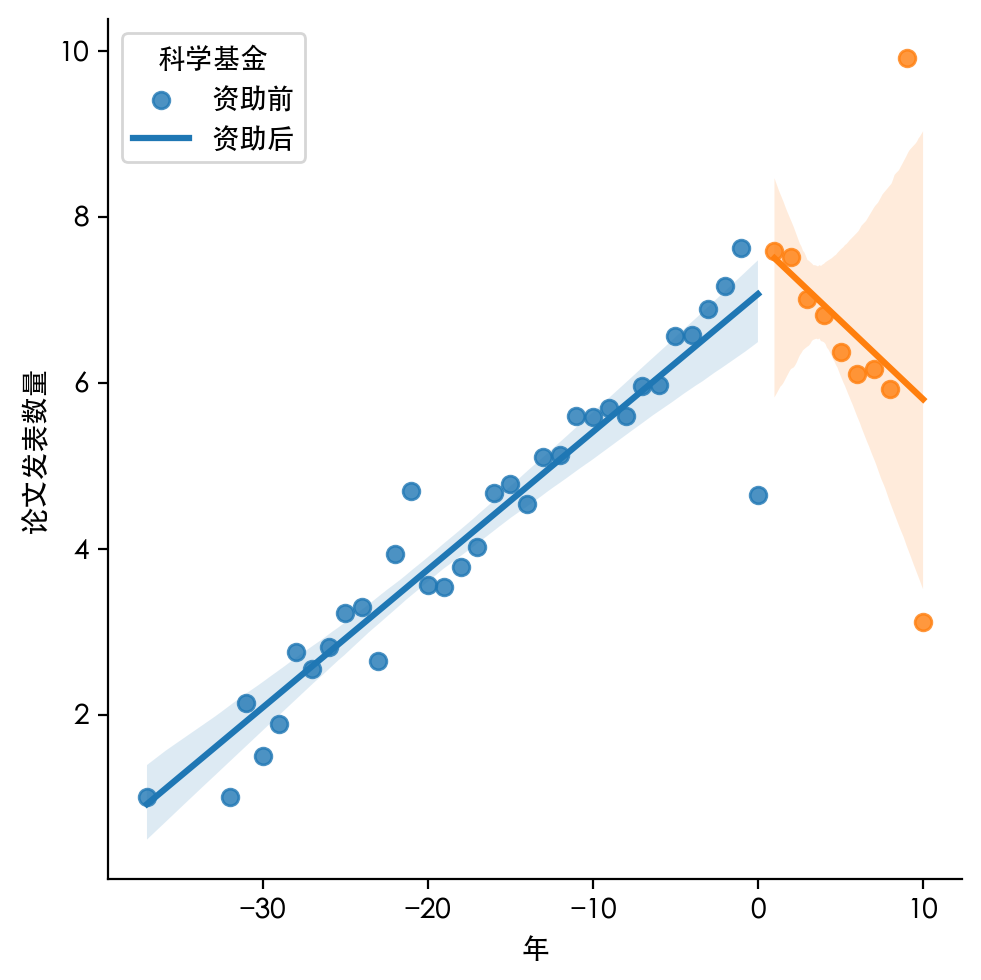

In [144]:
pub_grant_scatter['after_grant'] = pub_grant_scatter['grant_t'] >0 
#sns.regplot(x=pub_grant_scatter.grant_t, y=pub_grant_scatter.author_eid)
g = sns.lmplot(data = pub_grant_scatter, x='grant_t', y='author_eid',hue='after_grant',legend=False)
plt.legend(title='科学基金', loc='upper left', labels=['资助前', '资助后'])
plt.xlabel('年')
plt.ylabel('论文发表数量')

plt.show(g)
g.savefig('/Users/yansong/Nutstore Files/基金研究/graph_updated/pub_bf_af.png')

In [145]:
ms_nsfc_pubs.to_csv("/Users/yansong/Nutstore Files/基金研究/data/2013--2022面青/ms_reg_type1_coded.csv")

In [146]:
ms_nsfc_pubs.head()

,author_name,申请部门,year,author_eid,citations,coauthors,申请人,nsfc_code,立项年份,_merge,grant_t,after_grant
0,Bai Lihui,物理学院,2005,4,16,6.000000,柏利慧,A,2022,both,-17,0
1,Bai Lihui,物理学院,2006,8,40,7.750000,柏利慧,A,2022,both,-16,0
2,Bai Lihui,物理学院,2007,6,178,7.833333,柏利慧,A,2022,both,-15,0
3,Bai Lihui,物理学院,2008,2,211,7.500000,柏利慧,A,2022,both,-14,0
4,Bai Lihui,物理学院,2009,1,1,4.000000,柏利慧,A,2022,both,-13,0


## 期刊分区数据
- 先把论文发表的期刊名字匹配起来
- 再和JCR期刊分区匹配起来
- 再进行transform
- 和自科数据合并
- 输出文件，在stata内进行回归

In [147]:
# root_dir = "/Users/yansong/Nutstore Files/论文发表2013-2020/ms_scopusPub/xlsx"
# os.chdir(root_dir)
# authors = os.listdir(root_dir)
# unique_lists = []

# for author_file in authors:
#     if '.xlsx' in author_file:
#         author_pubs = pd.read_excel(author_file)
#         unique_lists.append(author_pubs)

# pub_names = pd.concat(unique_lists)
# pub_names = pub_names[['eid','author_eid','publicationname']]

In [148]:
def extract_journal(journal_name):

    # get the index of the separator 
    # if index = -1, return entire string
    # if index != -1, return from index to end of string 
    sep_index = journal_name.rfind('/')+1
    if sep_index == 0:
        journal_eng = journal_name 
    else:
        journal_eng = journal_name[sep_index:]
    return journal_eng
pub_names['journal_name'] = pub_names['publicationname'].apply(extract_journal)

NameError: name 'pub_names' is not defined

In [ ]:
qn_df = ms_author_pubs.merge(pub_names,how='left',on=['eid','author_eid'],indicator=True)
qn_df.drop(columns='_merge',inplace=True)

In [ ]:
root_dir = "/Users/yansong/Nutstore Files/基金研究/data/2013--2022面青"
os.chdir(root_dir)
JCR2022 = pd.read_stata("JCR2022.dta")
JCR2022 = JCR2022[['journal_group','j_group1','j_group2','j_group3','j_group4','journal_name']]

In [ ]:
qn_df = qn_df.merge(JCR2022,how='left',on=['journal_name'],indicator=True)

In [ ]:
qn_df._merge.value_counts()

In [ ]:
qn_df['counter'] = 1

In [ ]:
qn_df_grouped = qn_df.groupby(['author_name','school_1','year'])[['j_group1','j_group2','j_group3','j_group4','counter']].sum().reset_index()


In [ ]:
qn_df_grouped.head(1)

In [ ]:
qn_df_grouped['year'] = pd.to_numeric(qn_df_grouped['year'], errors='coerce')
qn_df_grouped.drop(qn_df_grouped.loc[qn_df_grouped['year']<2003].index, inplace=True)
qn_df_grouped.drop(qn_df_grouped.loc[qn_df_grouped['year']>2022].index, inplace=True)
qn_df_grouped.rename(columns={'school_1':'申请部门'},inplace=True)

In [ ]:
ms_nsfc_df = qn_df_grouped.merge(ms_nsfc,how='inner',on=['author_name','申请部门'],indicator=True)

In [ ]:
ms_nsfc_df.to_csv("/Users/yansong/Nutstore Files/基金研究/data/2013--2022面青/qn_reg_type3.csv")